# Day 50: CBAM 注意力机制


---

## 1. CBAM 注意力机制概述

### 1.1 什么是 CBAM？

**CBAM (Convolutional Block Attention Module)** 是一种能够集成到任何卷积神经网络架构中的注意力模块。

### 1.2 核心目标

- 通过学习的方式，**自动获取**特征图在通道和空间维度上的重要性
- 对特征图进行**自适应调整**，增强重要特征，抑制不重要特征
- 提升模型的**特征表达能力**和性能

简单来说，CBAM 就像是给模型装上了"智能眼镜"，让模型能够更精准地看到图像中关键的部分。

### 1.3 CBAM 的组成

CBAM 由两个主要部分组成：

- **通道注意力模块** (Channel Attention)：分析"哪些通道的特征更关键"
- **空间注意力模块** (Spatial Attention)：定位"关键特征在图像中的具体位置"

### 1.4 CBAM vs SE 注意力

- **SE 通道注意力的局限**：仅关注"哪些通道重要"，未考虑"重要信息在空间中的位置"
- **CBAM 的突破**：二者结合，让模型同时学会"关注什么"和"关注哪里"

### 1.5 数据流向

```
输入特征图 -> 通道注意力模块 -> 空间注意力模块 -> 输出增强后的特征图
```

### 1.6 CBAM 的特点

- **轻量级设计**：仅增加少量计算量
- **即插即用**：无需修改原有模型主体结构
- **双重优化**：同时提升通道和空间维度的特征质量

---

## 2. 通道注意力模块 (Channel Attention)

### 2.1 模块原理

通道注意力模块通过**全局平均池化**和**全局最大池化**两种方式来捕获通道间的关系。

### 2.2 代码实现

In [1]:
import torch
import torch.nn as nn


class ChannelAttention(nn.Module):
    """
    通道注意力机制模块
    功能：学习各通道的重要性权重，增强重要通道，抑制不重要通道
    """
    
    def __init__(self, in_channels, ratio=16):
        """
        初始化通道注意力机制
        参数:
            in_channels: 输入特征图的通道数
            ratio: 降维比例，用于减少参数量，默认为16
        """
        super().__init__()
        # 全局平均池化：保留通道间的平均值信息
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        # 全局最大池化：保留通道间的最显著特征
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        # 共享全连接层：降维 -> ReLU -> 升维
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // ratio, bias=False),
            nn.ReLU(),
            nn.Linear(in_channels // ratio, in_channels, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        """前向传播"""
        b, c, h, w = x.shape
        # 平均池化分支
        avg_out = self.fc(self.avg_pool(x).view(b, c))
        # 最大池化分支
        max_out = self.fc(self.max_pool(x).view(b, c))
        # 相加并通过Sigmoid得到权重
        attention = self.sigmoid(avg_out + max_out).view(b, c, 1, 1)
        return x * attention

---

## 3. 空间注意力模块 (Spatial Attention)

### 3.1 模块原理

空间注意力模块在通道维度上进行池化，生成空间权重图。

### 3.2 代码实现

In [2]:
class SpatialAttention(nn.Module):
    """
    空间注意力机制模块
    功能：学习空间位置的重要性权重
    """
    
    def __init__(self, kernel_size=7):
        super().__init__()
        # 卷积层：2通道输入，1通道输出
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        """前向传播"""
        # 通道平均池化
        avg_out = torch.mean(x, dim=1, keepdim=True)
        # 通道最大池化
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        # 拼接并卷积
        pool_out = torch.cat([avg_out, max_out], dim=1)
        attention = self.conv(pool_out)
        return x * self.sigmoid(attention)

---

## 4. 完整的 CBAM 模块

将通道注意力和空间注意力串联使用。

In [3]:
class CBAM(nn.Module):
    """CBAM完整模块：通道注意力 + 空间注意力"""
    
    def __init__(self, in_channels, ratio=16, kernel_size=7):
        super().__init__()
        self.channel_attention = ChannelAttention(in_channels, ratio)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, x):
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        return x

---

## 5. 实践：集成 CBAM 的 CNN 模型

### 5.1 数据准备

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'使用设备: {device}')

# 数据预处理
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# 加载数据集
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

print(f'训练集大小: {len(train_dataset)}')
print(f'测试集大小: {len(test_dataset)}')

使用设备: cuda
训练集大小: 50000
测试集大小: 10000


### 5.2 定义带 CBAM 的 CNN 模型

In [7]:
class CBAM_CNN(nn.Module):
    """集成 CBAM 注意力机制的 CNN 模型"""
    
    def __init__(self, num_classes=10):
        super().__init__()
        # 第一个卷积块
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.cbam1 = CBAM(64)
        self.pool1 = nn.MaxPool2d(2)
        
        # 第二个卷积块
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.cbam2 = CBAM(128)
        self.pool2 = nn.MaxPool2d(2)
        
        # 第三个卷积块
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.cbam3 = CBAM(256)
        self.pool3 = nn.AdaptiveAvgPool2d(1)
        
        # 分类器
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.pool1(self.cbam1(self.conv1(x)))
        x = self.pool2(self.cbam2(self.conv2(x)))
        x = self.pool3(self.cbam3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

### 5.3 模型配置

In [8]:
# 创建模型
model = CBAM_CNN(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

print(model)

CBAM_CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (cbam1): CBAM(
    (channel_attention): ChannelAttention(
      (avg_pool): AdaptiveAvgPool2d(output_size=1)
      (max_pool): AdaptiveMaxPool2d(output_size=1)
      (fc): Sequential(
        (0): Linear(in_features=64, out_features=4, bias=False)
        (1): ReLU()
        (2): Linear(in_features=4, out_features=64, bias=False)
      )
      (sigmoid): Sigmoid()
    )
    (spatial_attention): SpatialAttention(
      (conv): Conv2d(2, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
      (sigmoid): Sigmoid()
    )
  )
  (pool1): MaxPool2d(kernel_size=2,

/home/ubuntu24/anaconda3/envs/torch-gpu/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


---

## 6. 模型训练与评估

### 6.1 训练函数

In [9]:
def train(model, train_loader, test_loader, criterion, optimizer, scheduler, device, epochs):
    train_acc_history, test_acc_history = [], []
    train_loss_history, test_loss_history = [], []
    all_iter_losses, iter_indices = [], []
    global_iter = 0
    
    for epoch in range(epochs):
        # 训练阶段
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            iter_loss = loss.item()
            all_iter_losses.append(iter_loss)
            iter_indices.append(global_iter)
            global_iter += 1
            running_loss += iter_loss
            
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
            
            if (batch_idx + 1) % 100 == 0:
                print(f'Epoch: {epoch+1}/{epochs} | Batch: {batch_idx+1}/{len(train_loader)} | Loss: {iter_loss:.4f}')
        
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100. * correct / total
        train_acc_history.append(epoch_train_acc)
        train_loss_history.append(epoch_train_loss)
        
        # 测试阶段
        model.eval()
        test_loss, correct_test, total_test = 0, 0, 0
        
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += criterion(output, target).item()
                _, predicted = output.max(1)
                total_test += target.size(0)
                correct_test += predicted.eq(target).sum().item()
        
        epoch_test_loss = test_loss / len(test_loader)
        epoch_test_acc = 100. * correct_test / total_test
        test_acc_history.append(epoch_test_acc)
        test_loss_history.append(epoch_test_loss)
        
        scheduler.step(epoch_test_loss)
        print(f'Epoch {epoch+1}/{epochs} | Train Acc: {epoch_train_acc:.2f}% | Test Acc: {epoch_test_acc:.2f}%')
    
    plot_iter_losses(all_iter_losses, iter_indices)
    plot_epoch_metrics(train_acc_history, test_acc_history, train_loss_history, test_loss_history)
    return epoch_test_acc

### 6.2 可视化函数

In [10]:
def plot_iter_losses(losses, indices):
    plt.figure(figsize=(10, 4))
    plt.plot(indices, losses, 'b-', alpha=0.7)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)
    plt.show()

def plot_epoch_metrics(train_acc, test_acc, train_loss, test_loss):
    epochs = range(1, len(train_acc) + 1)
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, 'b-', label='Train')
    plt.plot(epochs, test_acc, 'r-', label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, 'b-', label='Train')
    plt.plot(epochs, test_loss, 'r-', label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

### 6.3 开始训练

开始训练...
Epoch: 1/50 | Batch: 100/391 | Loss: 1.4769
Epoch: 1/50 | Batch: 200/391 | Loss: 1.3241
Epoch: 1/50 | Batch: 300/391 | Loss: 1.1107
Epoch 1/50 | Train Acc: 51.92% | Test Acc: 63.62%
Epoch: 2/50 | Batch: 100/391 | Loss: 0.9245
Epoch: 2/50 | Batch: 200/391 | Loss: 0.8254
Epoch: 2/50 | Batch: 300/391 | Loss: 0.7969
Epoch 2/50 | Train Acc: 68.88% | Test Acc: 69.66%
Epoch: 3/50 | Batch: 100/391 | Loss: 0.7424
Epoch: 3/50 | Batch: 200/391 | Loss: 0.8422
Epoch: 3/50 | Batch: 300/391 | Loss: 0.8314
Epoch 3/50 | Train Acc: 74.75% | Test Acc: 62.86%
Epoch: 4/50 | Batch: 100/391 | Loss: 0.7089
Epoch: 4/50 | Batch: 200/391 | Loss: 0.4659
Epoch: 4/50 | Batch: 300/391 | Loss: 0.6045
Epoch 4/50 | Train Acc: 78.08% | Test Acc: 76.47%
Epoch: 5/50 | Batch: 100/391 | Loss: 0.7523
Epoch: 5/50 | Batch: 200/391 | Loss: 0.4497
Epoch: 5/50 | Batch: 300/391 | Loss: 0.8145
Epoch 5/50 | Train Acc: 80.15% | Test Acc: 77.04%
Epoch: 6/50 | Batch: 100/391 | Loss: 0.5655
Epoch: 6/50 | Batch: 200/391 | Loss: 0

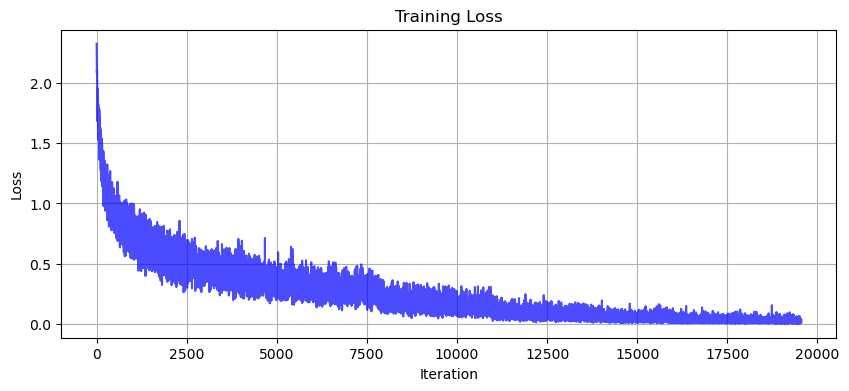

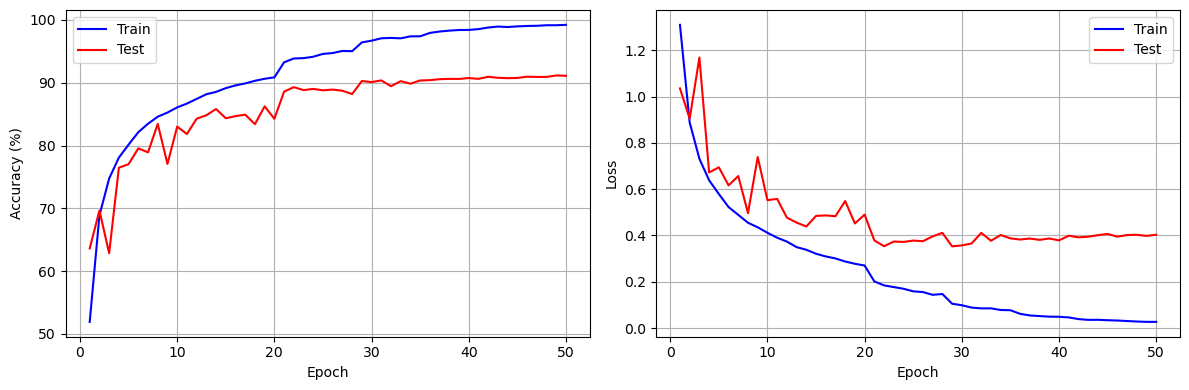

训练完成！最终测试准确率: 91.11%


In [11]:
epochs = 50
print('开始训练...')
final_accuracy = train(model, train_loader, test_loader, criterion, optimizer, scheduler, device, epochs)
print(f'训练完成！最终测试准确率: {final_accuracy:.2f}%')

---

## 总结

1. **CBAM 模块**由**通道注意力**和**空间注意力**两部分组成
2. **通道注意力**关注"哪些通道重要"
3. **空间注意力**关注"哪里重要"
4. CBAM 是**即插即用**的模块，可以集成到各种 CNN 架构中